In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
28*28

In [ ]:
# Load MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flatten
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# Binarize AND enforce float32 (IMPORTANT)
x_train = np.where(x_train > 0.5, 1.0, 0.0).astype(np.float32)
x_test = np.where(x_test > 0.5, 1.0, 0.0).astype(np.float32)


In [ ]:
class RBM(tf.Module):
    def __init__(self, n_visible, n_hidden, learning_rate=0.01):
        super().__init__()
        self.lr = learning_rate

        # Parameters (float32 by default)
        self.W = tf.Variable(
            tf.random.normal([n_visible, n_hidden], stddev=0.01, dtype=tf.float32)
        )
        self.v_bias = tf.Variable(tf.zeros([n_visible], dtype=tf.float32))
        self.h_bias = tf.Variable(tf.zeros([n_hidden], dtype=tf.float32))

        # Converts probabilities → binary samples (0 or 1)

        #   Used because RBM units are stochastic

        #   How it works:

        #   Generate random values between 0 and 1

        #   Compare with probabilities

        #   Output:

        #   1 if prob > random

        #   0 otherwise

    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

    def hidden_from_visible(self, v):
        v = tf.cast(v, tf.float32)  # safety cast
        h_prob = tf.nn.sigmoid(tf.matmul(v, self.W) + self.h_bias)
        h_sample = self.sample_prob(h_prob)
        return h_prob, h_sample

    def visible_from_hidden(self, h):
        h = tf.cast(h, tf.float32)  # safety cast
        v_prob = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.v_bias)
        v_sample = self.sample_prob(v_prob)
        return v_prob, v_sample

    def train_step(self, v0):
        v0 = tf.cast(v0, tf.float32)

        # Positive phase
        h0_prob, h0_sample = self.hidden_from_visible(v0)

        # Negative phase
        v1_prob, v1_sample = self.visible_from_hidden(h0_sample)
        h1_prob, _ = self.hidden_from_visible(v1_sample)

        # Contrastive Divergence update
        self.W.assign_add(
            self.lr * (
                tf.matmul(tf.transpose(v0), h0_prob) -
                tf.matmul(tf.transpose(v1_sample), h1_prob)
            )
        )

        self.v_bias.assign_add(self.lr * tf.reduce_mean(v0 - v1_sample, axis=0))
        self.h_bias.assign_add(self.lr * tf.reduce_mean(h0_prob - h1_prob, axis=0))

        # Reconstruction loss
        loss = tf.reduce_mean(tf.square(v0 - v1_prob))
        return loss


In [ ]:
rbm = RBM(n_visible=784, n_hidden=256, learning_rate=0.05)

batch_size = 64
epochs = 10

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(10000).batch(batch_size)

for epoch in range(epochs):
    total_loss = 0
    for batch in dataset:
        loss = rbm.train_step(batch)
        total_loss += loss.numpy()

    print(f"Epoch {epoch + 1}, Reconstruction Loss: {total_loss:.4f}")


Epoch 1, Reconstruction Loss: 61.2335
Epoch 2, Reconstruction Loss: 50.5586
Epoch 3, Reconstruction Loss: 46.7991
Epoch 4, Reconstruction Loss: 43.4395
Epoch 5, Reconstruction Loss: 41.1447
Epoch 6, Reconstruction Loss: 39.6934
Epoch 7, Reconstruction Loss: 38.3313
Epoch 8, Reconstruction Loss: 37.5507
Epoch 9, Reconstruction Loss: 36.7029
Epoch 10, Reconstruction Loss: 36.0488


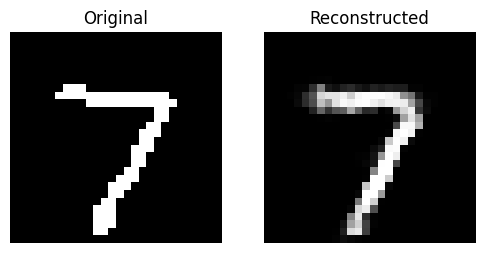

In [ ]:
# Take one test image
sample = x_test[:1]

# Reconstruct
h_prob, h_sample = rbm.hidden_from_visible(sample)
v_recon_prob, _ = rbm.visible_from_hidden(h_sample)

# Plot
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(sample.reshape(28, 28), cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed")
plt.imshow(v_recon_prob.numpy().reshape(28, 28), cmap="gray")
plt.axis("off")

plt.show()
